# Water4Cities Infrastructure to support Data Mining
### W4C Webinar #1
Klemen Kenda, Matej Senožetnik, JSI @ SingularLogic, Nov 24th 2017

## Importing libraries

In [191]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook
%matplotlib inline

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import seaborn as sb

## Loading and formatting the data

In [4]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id=85069";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Checking loaded data

In [5]:
# string/tabular view
# len(jsonStr), jsonStr[0:100] and df[0:5]
df[0:5]

,Value,Date
0,277.80,2015-01-01
1,277.77,2015-01-02
2,277.73,2015-01-03
3,277.70,2015-01-04
4,277.65,2015-01-05


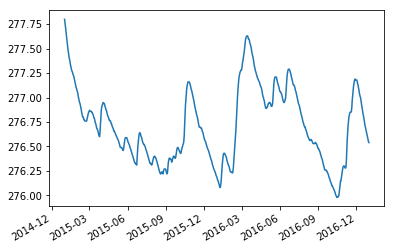

In [8]:
# plotting the data
# format date axis
fig, ax = plt.subplots(); fig.autofmt_xdate();
# plot
ax.plot(df['Date'], df['Value']);
# show plot
plt.show();

## Loading some additional data for modeling (weather)

In [10]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2014&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);
test = pd.read_csv(url);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);

In [11]:
dw[0:5]

,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin
Date,,,,,,,,
2015-01-01,70,0,0.0,13,2.1,-5.8,-3.0,-9.6
2015-01-02,83,0,0.0,12,2.1,-0.6,1.5,-5.5
2015-01-03,80,0,0.0,10,0.0,-1.0,0.6,-4.5
2015-01-04,20,0,0.2,8,7.9,3.1,10.3,-0.5
2015-01-05,50,0,0.0,4,5.9,3.0,8.5,0.0


## Data Fusion

In [192]:
# make date a key in our data
df.set_index('Date', inplace=True);

KeyError: 'Date'

In [25]:
df[0:5]

,Value
Date,
2015-01-01,277.80
2015-01-02,277.77
2015-01-03,277.73
2015-01-04,277.70
2015-01-05,277.65


In [148]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [68]:
# let's check it
ds[0:100]

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin
Date,,,,,,,,,
2015-01-01,277.80,70,0,0.0,13,2.1,-5.8,-3.0,-9.6
2015-01-02,277.77,83,0,0.0,12,2.1,-0.6,1.5,-5.5
2015-01-03,277.73,80,0,0.0,10,0.0,-1.0,0.6,-4.5
2015-01-04,277.70,20,0,0.2,8,7.9,3.1,10.3,-0.5
2015-01-05,277.65,50,0,0.0,4,5.9,3.0,8.5,0.0
2015-01-06,277.61,33,0,0.0,3,4.4,-0.4,4.9,-3.6
2015-01-07,277.57,50,0,0.0,3,1.1,-0.9,2.7,-2.7
2015-01-08,277.53,83,0,0.0,3,0.2,0.2,2.3,-4.1
2015-01-09,277.50,90,0,0.0,2,0.6,4.9,7.5,1.0


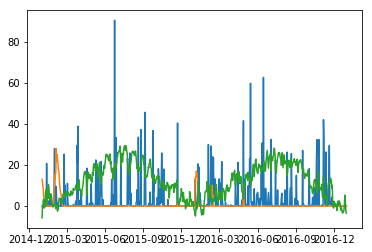

In [28]:
plt.figure()
#plt.plot(dw['CloudCover'])
plt.plot(dw['Percipitation'])
plt.plot(dw['Snow_blanket'])
plt.plot(dw['TemperatureAvg'])

## Exploratory data analysis
This is a very big deal for successful data mining; we will not go deep into this. We will just do some very basic visualizations.

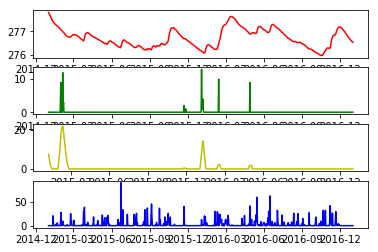

In [29]:
plt.figure(4);
plt.subplot(411);
plt.plot(ds.index, ds['Value'], 'r');
plt.subplot(412);
plt.plot(ds.index, ds['New_snow_blanket'], 'g');
plt.subplot(413);
plt.plot(ds.index, ds['Snow_blanket'].rolling(7).mean(), 'y');
plt.subplot(414);
plt.plot(ds.index, ds['Percipitation'], 'b');
plt.show();

## Let the fun begin!
# Data-driven modeling
How well can we describe groundwater level with tha available features?

In [30]:
# Let's prepare the data, we need a vector y with our groundwater level 
# and a matrix X of corresponding features
y = ds['Value'];
X = ds.iloc[:, 1:9];

In [31]:
# linear regression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


#regressor = linear_model.LinearRegression();
#regressor = DecisionTreeRegressor();
#regressor = SVR();
#regressor = RandomForestRegressor();
regressor = GradientBoostingRegressor();

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(regressor, X, y, cv = 10);


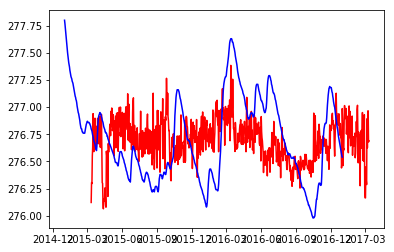

In [32]:
# plot modeling results
fig, ax = plt.subplots();
#+80 -> zamaknemo predikcijo da malo bolj sovpada s pravimi vrednostmi
ax.plot(y.index+70, predicted, 'r');
ax.plot(y, 'b');
plt.show();

In [33]:
# evaluate model
mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.225973126659689, -0.5090821658365055)

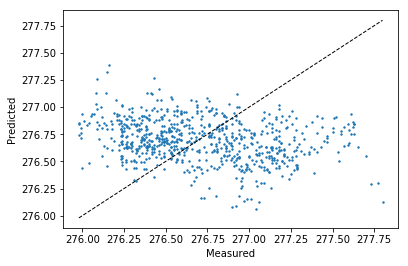

In [34]:
# scatterplot
fig, ax = plt.subplots();
ax.scatter(y, predicted, s=2);
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1);
ax.set_xlabel('Measured');
ax.set_ylabel('Predicted');
plt.show();

## Are we looking at a good target variable?

In [35]:
# make new X and y
y = ds['Value'][:]
X = ds.iloc[1:, 1:10];

In [36]:
y = ds['Value'] - ds['Value'].shift(1)
y = y[1:]

## How about proper feature engineering?
Domain knowledge can help!

See data fusion / stream modeling demo!

In [37]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

In [38]:
window = signal.triang(5,sym=False)

In [39]:
ds["DValue"] = ds['Value'] - ds['Value'].shift(1)

In [40]:
ds["Prec_1d"] = ds['Percipitation'] - ds['Percipitation'].shift(1)
ds["Prec_2d"] = ds['Percipitation'] - ds['Percipitation'].shift(2)
ds["Prec_3d"] = ds['Percipitation'] - ds['Percipitation'].shift(3)
ds["Prec_4d"] = ds['Percipitation'] - ds['Percipitation'].shift(4)
ds["Prec_5d"] = ds['Percipitation'] - ds['Percipitation'].shift(5)
ds["Prec_6d"] = ds['Percipitation'] - ds['Percipitation'].shift(6)
ds["Prec_7d"] = ds['Percipitation'] - ds['Percipitation'].shift(7)
ds["Prec_8d"] = ds['Percipitation'] - ds['Percipitation'].shift(8)
ds["Prec_9d"] = ds['Percipitation'] - ds['Percipitation'].shift(9)
ds["Prec_10d"] = ds['Percipitation'] - ds['Percipitation'].shift(10)
ds["Prec_11d"] = ds['Percipitation'] - ds['Percipitation'].shift(11)
ds["Prec_12d"] = ds['Percipitation'] - ds['Percipitation'].shift(12)
ds["Prec_13d"] = ds['Percipitation'] - ds['Percipitation'].shift(13)
ds["Prec_14d"] = ds['Percipitation'] - ds['Percipitation'].shift(14)
ds["Prec_15d"] = ds['Percipitation'] - ds['Percipitation'].shift(15)
ds["Prec_16d"] = ds['Percipitation'] - ds['Percipitation'].shift(16)
ds["Prec_17d"] = ds['Percipitation'] - ds['Percipitation'].shift(17)
ds["Prec_18d"] = ds['Percipitation'] - ds['Percipitation'].shift(18)
ds["Prec_19d"] = ds['Percipitation'] - ds['Percipitation'].shift(19)
ds["Prec_20d"] = ds['Percipitation'] - ds['Percipitation'].shift(20)
ds["Prec_21d"] = ds['Percipitation'] - ds['Percipitation'].shift(21)
ds["Prec_22d"] = ds['Percipitation'] - ds['Percipitation'].shift(22)
ds["Prec_23d"] = ds['Percipitation'] - ds['Percipitation'].shift(23)
ds["Prec_24d"] = ds['Percipitation'] - ds['Percipitation'].shift(24)
ds["Prec_25d"] = ds['Percipitation'] - ds['Percipitation'].shift(25)
ds["Prec_50d"] = ds['Percipitation'] - ds['Percipitation'].shift(50)
ds["Prec_60d"] = ds['Percipitation'] - ds['Percipitation'].shift(60)
ds["Prec_65d"] = ds['Percipitation'] - ds['Percipitation'].shift(65)
ds["Prec_70d"] = ds['Percipitation'] - ds['Percipitation'].shift(70)
ds["Prec_75d"] = ds['Percipitation'] - ds['Percipitation'].shift(75)
ds["Prec_80d"] = ds['Percipitation'] - ds['Percipitation'].shift(80)
ds["Prec_100d"] = ds['Percipitation'] - ds['Percipitation'].shift(100)
ds["Prec_150d"] = ds['Percipitation'] - ds['Percipitation'].shift(150)
ds["Prec_200d"] = ds['Percipitation'] - ds['Percipitation'].shift(200)
ds["Prec_250d"] = ds['Percipitation'] - ds['Percipitation'].shift(250)
ds["Prec_275d"] = ds['Percipitation'] - ds['Percipitation'].shift(275)
ds["Prec_295d"] = ds['Percipitation'] - ds['Percipitation'].shift(295)
ds["Prec_300d"] = ds['Percipitation'] - ds['Percipitation'].shift(300)
ds["Prec_305d"] = ds['Percipitation'] - ds['Percipitation'].shift(305)
ds["Prec_350d"] = ds['Percipitation'] - ds['Percipitation'].shift(350)
ds["Prec_400d"] = ds['Percipitation'] - ds['Percipitation'].shift(400)
ds["Prec_450d"] = ds['Percipitation'] - ds['Percipitation'].shift(450)
ds["Prec_500d"] = ds['Percipitation'] - ds['Percipitation'].shift(500)

In [379]:
ds["Prec_1d_1d"] = ds["Prec_1d"].rolling(5, win_type='triang').sum()
ds["Prec_2d_2d"] = ds["Prec_2d"].rolling(5, win_type='triang').sum()
ds["Prec_3d_3d"] = ds["Prec_3d"].rolling(5, win_type='triang').sum()
ds["Prec_4d_4d"] = ds["Prec_4d"].rolling(5, win_type='triang').sum()
ds["Prec_5d_5d"] = ds["Prec_5d"].rolling(5, win_type='triang').sum()
ds["Prec_6d_6d"] = ds["Prec_6d"].rolling(5, win_type='triang').sum()
ds["Prec_7d_7d"] = ds["Prec_7d"].rolling(5, win_type='triang').sum()
ds["Prec_8d_8d"] = ds["Prec_8d"].rolling(5, win_type='triang').sum()
ds["Prec_9d_9d"] = ds["Prec_9d"].rolling(5, win_type='triang').sum()
ds["Prec_10d_10d"] = ds["Prec_10d"].rolling(5, win_type='triang').sum()
ds["Prec_11d_11d"] = ds["Prec_11d"].rolling(5, win_type='triang').sum()
ds["Prec_12d_12d"] = ds["Prec_12d"].rolling(5, win_type='triang').sum()
ds["Prec_13d_13d"] = ds["Prec_13d"].rolling(5, win_type='triang').sum()
ds["Prec_14d_14d"] = ds["Prec_14d"].rolling(5, win_type='triang').sum()
ds["Prec_15d_15d"] = ds["Prec_15d"].rolling(5, win_type='triang').sum()
ds["Prec_16d_16d"] = ds["Prec_16d"].rolling(5, win_type='triang').sum()
ds["Prec_17d_17d"] = ds["Prec_17d"].rolling(5, win_type='triang').sum()
ds["Prec_18d_18d"] = ds["Prec_18d"].rolling(5, win_type='triang').sum()
ds["Prec_19d_19d"] = ds["Prec_19d"].rolling(5, win_type='triang').sum()
ds["Prec_20d_20d"] = ds["Prec_20d"].rolling(5, win_type='triang').sum()
ds["Prec_21d_21d"] = ds["Prec_21d"].rolling(5, win_type='triang').sum()
ds["Prec_22d_22d"] = ds["Prec_22d"].rolling(5, win_type='triang').sum()
ds["Prec_23d_23d"] = ds["Prec_23d"].rolling(5, win_type='triang').sum()
ds["Prec_24d_24d"] = ds["Prec_24d"].rolling(5, win_type='triang').sum()
ds["Prec_25d_25d"] = ds["Prec_25d"].rolling(5, win_type='triang').sum()
ds["Prec_50d_50d"] = ds["Prec_50d"].rolling(5, win_type='triang').sum()
ds["Prec_60d_60d"] = ds["Prec_60d"].rolling(5, win_type='triang').sum()
ds["Prec_65d_65d"] = ds["Prec_65d"].rolling(5, win_type='triang').sum()
ds["Prec_70d_70d"] = ds["Prec_70d"].rolling(5, win_type='triang').sum()
ds["Prec_75d_75d"] = ds["Prec_75d"].rolling(5, win_type='triang').sum()
ds["Prec_80d_80d"] = ds["Prec_80d"].rolling(5, win_type='triang').sum()
ds["Prec_100d_100d"] = ds["Prec_100d"].rolling(5, win_type='triang').sum()
ds["Prec_150d_150d"] = ds["Prec_150d"].rolling(5, win_type='triang').sum()
ds["Prec_200d_200d"] = ds["Prec_200d"].rolling(5, win_type='triang').sum()
ds["Prec_250d_250d"] = ds["Prec_250d"].rolling(5, win_type='triang').sum()
ds["Prec_275d_275d"] = ds["Prec_275d"].rolling(5, win_type='triang').sum()
ds["Prec_295d_295d"] = ds["Prec_295d"].rolling(5, win_type='triang').sum()
ds["Prec_300d_300d"] = ds["Prec_300d"].rolling(5, win_type='triang').sum()
ds["Prec_305d_305d"] = ds["Prec_305d"].rolling(5, win_type='triang').sum()
ds["Prec_350d_350d"] = ds["Prec_350d"].rolling(5, win_type='triang').sum()
ds["Prec_400d_400d"] = ds["Prec_400d"].rolling(5, win_type='triang').sum()
ds["Prec_450d_450d"] = ds["Prec_450d"].rolling(5, win_type='triang').sum()
ds["Prec_500d_500d"] = ds["Prec_500d"].rolling(5, win_type='triang').sum()

In [41]:
ds.head()

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin,DValue,...,Prec_200d,Prec_250d,Prec_275d,Prec_295d,Prec_300d,Prec_305d,Prec_350d,Prec_400d,Prec_450d,Prec_500d
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,277.80,70,0,0.0,13,2.1,-5.8,-3.0,-9.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,277.77,83,0,0.0,12,2.1,-0.6,1.5,-5.5,-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,277.73,80,0,0.0,10,0.0,-1.0,0.6,-4.5,-0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,277.70,20,0,0.2,8,7.9,3.1,10.3,-0.5,-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,277.65,50,0,0.0,4,5.9,3.0,8.5,0.0,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
sb.pairplot(ds)

TypeError: 'data' must be pandas DataFrame object, not: <class 'numpy.ndarray'>

In [ ]:
#sb.pairplot(ds).savefig('output-pairplot.png')

In [381]:
ds.corr()

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin,DValue,...,Prec_200d_200d,Prec_250d_250d,Prec_275d_275d,Prec_295d_295d,Prec_300d_300d,Prec_305d_305d,Prec_350d_350d,Prec_400d_400d,Prec_450d_450d,Prec_500d_500d
Value,1.000000,-0.003858,-0.002169,-0.074592,0.064040,-0.014578,-0.178222,-0.162254,-0.206844,-0.051989,...,-0.024552,0.004436,-0.108731,-0.125417,-0.099500,-0.066152,0.057593,0.094712,0.074505,0.092124
CloudCover,-0.003858,1.000000,0.122452,0.219788,0.162879,-0.832740,-0.315040,-0.429054,-0.138423,0.213588,...,0.131426,0.070756,0.166791,0.273608,0.276016,0.163306,0.196257,0.135659,0.051437,0.144168
New_snow_blanket,-0.002169,0.122452,1.000000,0.182088,0.518093,-0.111978,-0.162496,-0.171834,-0.143569,-0.023698,...,0.000424,0.038180,0.027635,0.086652,0.073937,0.022480,0.058686,0.092789,-0.028010,NaN
Percipitation,-0.074592,0.219788,0.182088,1.000000,0.029835,-0.178188,-0.010982,-0.044188,0.062845,0.328638,...,0.209463,0.126543,0.236192,0.254273,0.233129,0.260072,0.169544,0.238529,0.159790,0.023501
Snow_blanket,0.064040,0.162879,0.518093,0.029835,1.000000,-0.178759,-0.305313,-0.317375,-0.294889,-0.123140,...,-0.013112,0.040078,0.041438,0.101765,0.088933,0.046310,0.064546,0.124092,-0.016027,NaN
Sun_duration,-0.014578,-0.832740,-0.111978,-0.178188,-0.178759,1.000000,0.596189,0.683709,0.407157,-0.126903,...,0.004120,0.028782,-0.041609,-0.115435,-0.161834,-0.076833,-0.098475,-0.080622,0.097384,0.019635
TemperatureAvg,-0.178222,-0.315040,-0.162496,-0.010982,-0.305313,0.596189,1.000000,0.979318,0.957507,-0.063458,...,0.139344,0.056031,0.027231,0.061906,0.018064,0.015591,-0.098152,-0.121334,0.103329,0.147854
TemperatureMax,-0.162254,-0.429054,-0.171834,-0.044188,-0.317375,0.683709,0.979318,1.000000,0.906927,-0.090399,...,0.101242,0.032948,-0.004510,0.021031,-0.035807,-0.019167,-0.132370,-0.138706,0.091491,0.092152
TemperatureMin,-0.206844,-0.138423,-0.143569,0.062845,-0.294889,0.407157,0.957507,0.906927,1.000000,-0.019962,...,0.161407,0.064283,0.062186,0.096476,0.074491,0.057068,-0.074484,-0.113380,0.089695,0.191045
DValue,-0.051989,0.213588,-0.023698,0.328638,-0.123140,-0.126903,-0.063458,-0.090399,-0.019962,1.000000,...,0.441268,0.497338,0.546541,0.578543,0.600560,0.649494,0.579172,0.515631,0.490534,0.401384


<IPython.core.display.Javascript object>


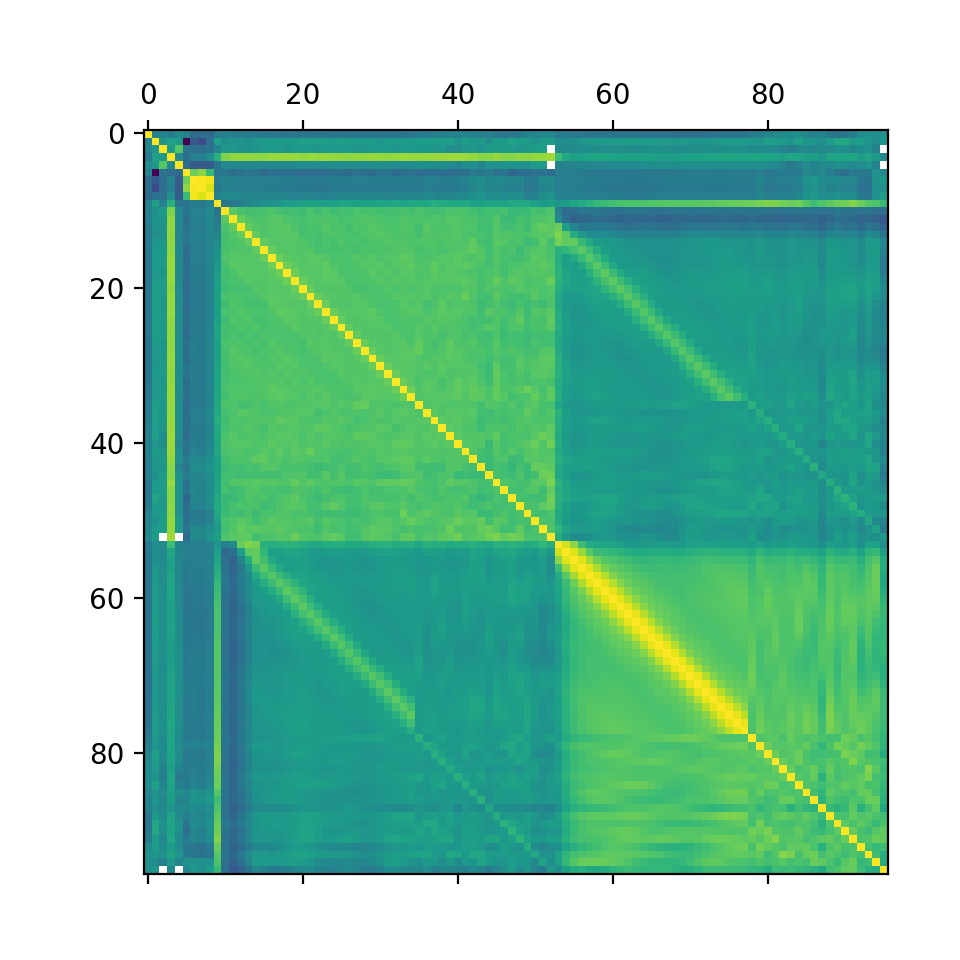

In [382]:
plt.matshow(ds.corr())

In [263]:
plt.savefig('output-corr-v4.png', dpi=300, bbox_inches='tight')

In [17]:
print(ds) 

             Value  CloudCover  New_snow_blanket  Percipitation  Snow_blanket  \
Date                                                                            
2015-01-01  277.80          70                 0            0.0            13   
2015-01-02  277.77          83                 0            0.0            12   
2015-01-03  277.73          80                 0            0.0            10   
2015-01-04  277.70          20                 0            0.2             8   
2015-01-05  277.65          50                 0            0.0             4   
2015-01-06  277.61          33                 0            0.0             3   
2015-01-07  277.57          50                 0            0.0             3   
2015-01-08  277.53          83                 0            0.0             3   
2015-01-09  277.50          90                 0            0.0             2   
2015-01-10  277.47          40                 0            0.0             0   
2015-01-11  277.44          

# Data process

In lines below we print the data from ds -> in first column there is the value of gorundwater and the we have values of cloud coverage, snow blanket, percipitation, termperature...

In [346]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [149]:
#Here we get out raw data without indexes and column names
ds = ds.values

In [150]:
#Tu se nahajajo vrednoti podtalnice - cilj
target = ds[:,0] 

In [151]:
#Tu se nahajoajo podatki, na podlagi katerih se bo napovedovala podtalnica
data = ds[:,1:]

In [152]:
#store feature matrix in "X"
X = data

In [153]:
#store response vector in "y"
y = target

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=False)

In [367]:
print(ds.shape)
print(X.shape)
print(y.shape)
print(len(X))
print(len(X_test) + len(X_train))
print(len(y))
print(len(y_test) + len(y_train))

(731, 9)
(731, 8)
(731,)
731
731
731
731


# KNeighbors

KNeighbors score depends on n_neighbors. Bigger the number of n_neighbors, lower np.sqrt(mean_squared_error)

In [380]:
from sklearn.neighbors import KNeighborsRegressor

In [381]:
knn = KNeighborsRegressor(n_neighbors=15)

In [382]:
knn = knn.fit(X_train, y_train)

In [383]:
y_pred = knn.predict(X_test) 

In [372]:
#print(knn.score(y_test, y_pred))

print(y_pred.reshape(-1,1) ,"-------", y_test.reshape(-1,1))

[[276.533]
 [276.511]
 [276.555]
 [276.427]
 [276.542]
 [276.84 ]
 [276.581]
 [276.562]
 [276.598]
 [276.497]
 [276.553]
 [276.475]
 [276.393]
 [276.503]
 [276.398]
 [276.637]
 [276.457]
 [276.44 ]
 [276.517]
 [276.597]
 [276.455]
 [276.48 ]
 [276.488]
 [276.542]
 [276.591]
 [276.5  ]
 [276.408]
 [276.456]
 [276.41 ]
 [276.451]
 [276.403]
 [276.404]
 [276.501]
 [276.523]
 [276.533]
 [276.412]
 [276.419]
 [276.445]
 [276.427]
 [276.475]
 [276.509]
 [276.434]
 [276.514]
 [276.406]
 [276.416]
 [276.451]
 [276.454]
 [276.467]
 [276.451]
 [276.457]
 [276.544]
 [276.592]
 [276.393]
 [276.497]
 [276.484]
 [276.47 ]
 [276.456]
 [276.435]
 [276.439]
 [276.426]
 [276.444]
 [276.427]
 [276.451]
 [276.289]
 [276.427]
 [276.447]
 [276.445]
 [276.298]
 [276.378]
 [276.486]
 [276.451]
 [276.427]
 [276.445]
 [276.544]
 [276.416]
 [276.529]
 [276.509]
 [276.631]
 [276.704]
 [276.702]
 [276.508]
 [276.387]
 [276.369]
 [276.4  ]
 [276.585]
 [276.397]
 [276.428]
 [276.449]
 [276.525]
 [276.805]
 [276.475]

In [351]:
knn.score(y_pred.reshape(-1,1), y_test)

ValueError: query data dimension must match training data dimension

In [384]:
np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')[0])

0.4732818132439425

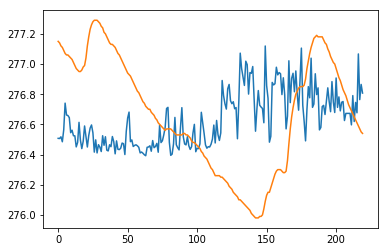

In [385]:
plt.plot(y_pred)
plt.plot(y_test)

# Linear Regresion

In [386]:
from sklearn.linear_model import LinearRegression

In [387]:
lr =  LinearRegression()

In [388]:
lr = lr.fit(X_train, y_train)

In [389]:
y_pred = lr.predict(X_test) 
print(lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [325]:
print(lr.score(y_pred,y_test))

ValueError: Expected 2D array, got 1D array instead:
array=[276.66866374 276.63158584 276.6109205  276.60868675 276.59836872
 276.60891267 276.63564999 276.64445835 276.69847201 276.69459292
 276.64494679 276.5950244  276.6285795  276.60479592 276.54613796
 276.53207884 276.67523797 276.49948302 276.61004514 276.61907378
 276.4090248  276.60722253 276.4845523  276.64925305 276.63409787
 276.55170067 276.61562934 276.57733929 276.51685955 276.48786731
 276.50229801 276.52888979 276.49037428 276.62513578 276.59501562
 276.60812777 276.52034765 276.53172493 276.49184001 276.55505728
 276.62612048 276.56039585 276.53197039 276.58918814 276.48534293
 276.49858315 276.5048295  276.49014608 276.47011977 276.50877449
 276.56423887 276.59382707 276.60075233 276.6684678  276.56584439
 276.55255948 276.54508948 276.4832388  276.50904258 276.51879753
 276.48036379 276.53888996 276.50448985 276.54213666 276.5322456
 276.54414356 276.49406526 276.5150054  276.57231604 276.58394645
 276.55286464 276.58017694 276.56456522 276.60166903 276.59498936
 276.6426411  276.65580721 276.53169642 276.74109656 276.62248374
 276.60592633 276.5603778  276.56821842 276.56257873 276.55763164
 276.5248081  276.5503948  276.54064824 276.61643708 276.64346952
 276.61593112 276.59138125 276.57894226 276.60506001 276.58915507
 276.63565455 276.52674273 276.57472196 276.6455584  276.50173737
 276.61934254 276.6105747  276.54710306 276.55726484 276.58974652
 276.58687053 276.56354431 276.62175734 276.55274137 276.54215556
 276.54324419 276.58162007 276.54770758 276.5624794  276.44473144
 276.58276442 276.63788423 276.6358267  276.62982227 276.77793959
 276.74113685 276.66602096 276.71934618 276.73445483 276.68016578
 276.73661166 276.73393467 276.65463063 276.64277894 276.60942927
 276.59249255 276.73894727 276.7411397  276.878414   276.79997014
 276.77740009 276.72256191 276.74814051 276.75222112 276.83774072
 276.84013377 276.706807   276.63053126 276.64038593 276.71989326
 276.67861888 276.69113862 276.67231209 276.64338645 276.84147023
 276.74730728 276.64145603 276.62108872 276.49488698 276.70389584
 276.75751552 276.77767646 276.84793881 276.69386902 276.83288744
 276.72019302 276.77317274 276.87330581 276.82351805 276.56921043
 276.76621874 276.7701963  276.83684724 276.83330717 276.82924682
 276.71768131 276.90654431 276.84310108 276.92988892 276.90481222
 276.75235256 276.67424202 276.64097224 276.67892885 276.66759268
 276.67270051 276.73415917 276.63300857 276.64993059 276.7099129
 276.72329372 276.84838691 276.83644124 276.93916225 276.89794902
 276.92021644 276.84075106 276.89206539 276.83992328 276.92355445
 276.85912403 276.89580524 276.92297115 276.93422473 276.91290112
 276.88205398 276.90931365 276.93503519 276.91830215 276.85554008
 276.91846298 276.99376101 276.94485475 276.9325617  276.94387927
 276.95418983 276.89719666 276.98182418 276.95894318 276.97608946
 276.87386481 276.95821035 276.86818254 276.91852332 276.97229302].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

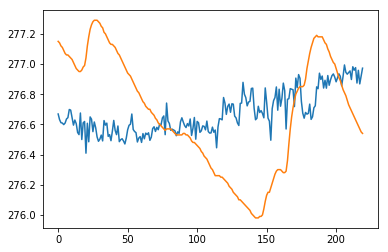

In [390]:
plt.plot(y_pred)
plt.plot(y_test)

In [391]:
np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values')[0])

0.4154398980419103

### Some notes:

Difference between classification and regression. We use classification if we want from our prediction to classify wheather our elemts are 0 or 1 or 2 or 3 etc. (Wheather they are tulips-1 or not-0). But we use regression to get exact numbers from our prediction (floats).

Sources:
- http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.predict
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
- https://stackoverflow.com/questions/13187778/convert-pandas-dataframe-to-numpy-array-preserving-index/37043071
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html